In [22]:
# Running the Trained Model from the best weight
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
import numpy as np
import cv2         
from glob import glob
import matplotlib.pyplot as plt                     
%matplotlib inline 
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image                  
from tqdm import tqdm
from keras.applications.resnet50 import preprocess_input, decode_predictions

In [23]:
bottleneck_features = np.load('bottleneck_features/DogInceptionV3Data.npz')
train_InceptionV3 = bottleneck_features['train']
valid_InceptionV3 = bottleneck_features['valid']
test_InceptionV3 = bottleneck_features['test']

In [24]:
inception_model = Sequential()
inception_model.add(GlobalAveragePooling2D(input_shape=train_InceptionV3.shape[1:]))
inception_model.add(Dense(1024, activation='relu'))
inception_model.add(Dropout(0.3))
inception_model.add(Dense(512, activation='relu'))
inception_model.add(Dropout(0.3))
inception_model.add(Dense(133, activation='softmax'))

inception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 133)               68229     
Total params: 2,691,205
Trainable params: 2,691,205
Non-trainable params: 0
_________________________________________________________________


In [25]:
inception_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [26]:
inception_model.load_weights('saved_models/weights.best.InceptionV3.hdf5')

In [34]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)        
    return len(faces) > 0


# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]
# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

In [28]:
def extract_InceptionV3(tensor):
    from keras.applications.inception_v3 import InceptionV3, preprocess_input
    return InceptionV3(weights='imagenet', include_top=False).predict(preprocess_input(tensor))

def dogBreed_predictor(path):
    # bottleneck features
    bottleneck_feature = extract_InceptionV3(path_to_tensor(path))
    # prediction vector
    predicted_vector = inception_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [72]:
folders = folders = [x[0] for x in os.walk("dogImages/test")]
def Breed_predict(path):
    if dog_detector(path):
        print("Hola Doge!,\n your predicted breed is {}".format(dogBreed_predictor(path)))
        img = cv2.imread(path)
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(cv_rgb)
        plt.show()
    elif face_detector(path):
        s = ("Hi there hooman!,\n you look like a {}".format(dogBreed_predictor(path)))
        print(s)
        s = s.split()[-1].strip()
        img = cv2.imread(path) 
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        f, ax = plt.subplots(1,2)
        ax[0].imshow(cv_rgb)
        #plt.imshow(cv_rgb)
        #plt.show()
        for folder in folders:
            if s in folder:
                breed_files = np.array(glob(folder+"/*"))
                img2 = cv2.imread(breed_files[1]) 
                cv_rgb2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
                ax[1].imshow(cv_rgb2)
                #plt.imshow(cv_rgb2)
                plt.show()         
    else:
        print("Hi there unknown being, I could not classify you!!!")

In [81]:
additional_image_files = np.array(glob("temp/*"))

Hi there hooman!,
 you look like a Belgian_sheepdog


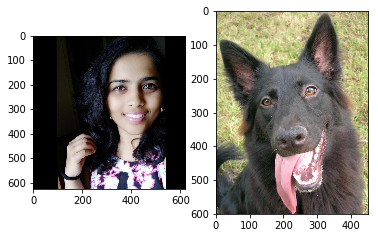

In [82]:
for image_path in additional_image_files:
    Breed_predict(image_path)